In [7]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
def plot(group,column,plot):
    g = df.groupby(group)[column].sum().sort_values(ascending=False)
    #print(g)
    pd.DataFrame(g).plot.bar(figsize=(15,9))
    plot.legend(loc=2, prop={'size': 6})
    
    #print(g)
def OLS(y,y_hat):
    return (y - y_hat).dot(y - y_hat)
def R2 (y, y_hat):
    return 1 - OLS(y, y_hat) / OLS(y,y.mean())

def OLS_L2(y,y_hat,l2,w):
    return (y - y_hat).dot(y - y_hat) + l2*w.T.dot(w)


# GD with no reularzition
def GD(X,y,eta):
    
    w = np.random.randn(X.shape[1])
    J = []
    epochs = int(1e3)

    for i in range(epochs):
        y_hat = X.dot(w)
        J.append(OLS(y,y_hat))
        w -= eta*X.T.dot(y_hat - y)
    
    return (J,w,y_hat)

def J_Va (X1,y1,X2,y2):
    
    cv = []
    
    N_train = X1.shape[0]
    N_cv = X2.shape[0]
    
    
    #我把 L2 调到了前面为了提升速度， 因为 只用 在 L1 = 0 的时候，L2 可以用 close form solution 这样可以快速找到 w
    #这样可以省去每个 L1 = 0 的那个loop 
    # 你也可以把 L2 地下的function 拿掉，把 L1 的 range 改成 从 0 开始， 也是一样的， L1 loop L2 loop 调位置也可以
    # 我之前就是把 L1 放在前面的， 但是，如果要用 L2 的 close form 就必须把 L2 放在前面
    
    #我的 error 是出在 L1 里面的 lambda1*np.sign(w)) 的位置 写错了。
    
    for lambda2 in range(0,2):
        
        w = np.linalg.solve(X1.T.dot(X1)+lambda2*np.eye(X1.shape[1]), X1.T.dot(y1))
        y_hat_train = X1.dot(w)
        y_hat_cv = X2.dot(w)
        J_train = (1/N_train)*OLS(y1, y_hat_train)
        J_cv = (1/N_cv)*OLS(y2, y_hat_cv)
        cv.append((J_train, J_cv, 0 , lambda2))
       #必须从1开始
        for lambda1 in range(1,3):
    
            eta = 1e-6
            epochs = int(1e3)
    
            for t in range(epochs):
                y_hat_train = X1.dot(w)
                w -= eta*(X1.T.dot(y_hat_train - y1) + lambda2*w + lambda1*np.sign(w))
        
            y_hat_cv = X2.dot(w)
    
            J_train = (1/N_train)*OLS(y1, y_hat_train)
            J_cv = (1/N_cv)*OLS(y2, y_hat_cv)
    
            cv.append((J_train, J_cv, lambda1, lambda2))
    return cv

In [9]:
np.random.seed(101)
df = pd.read_csv("./BlackFriday.csv")
df.drop(['User_ID', 'Product_ID'], axis=1, inplace = True)
df.fillna(0,inplace = True)
df["Occupation"] = df["Occupation"].map(str)
df["Marital_Status"] = df["Marital_Status"].map(str)
df["Age/Occupation"] = df["Age"] + df["Occupation"]
df["Age/Gender"] = df["Age"]+ df["Gender"]
df["Age/Marital"] = df["Age"] + df["Marital_Status"]
df["Gender/Marital"] = df["Gender"]+ df["Marital_Status"]
df["All_Product"] = df["Product_Category_1"] + df["Product_Category_2"]+ df["Product_Category_3"]
df["1_2_Product"] = df["Product_Category_1"] + df["Product_Category_2"]
df["1_3_Product"] = df["Product_Category_1"]+ df["Product_Category_3"]
df["2_3_Product"] = df["Product_Category_2"]+ df["Product_Category_3"]
columns_to_1hot = ["Age/Occupation","Age/Gender","Age/Marital","Gender/Marital","2_3_Product","1_3_Product","1_2_Product",'All_Product',"Stay_In_Current_City_Years",
                   'Gender','City_Category','Age','Occupation','Marital_Status',
                   'Product_Category_1','Product_Category_2','Product_Category_3']

df = pd.get_dummies(df, columns=columns_to_1hot)
df = df.sample(frac=1)

Train = int(df.shape[0] * 0.6)
Validate = int(df.shape[0] * 0.2)
Test = int(df.shape[0] - Train - Validate)

Train_Model =  df[:Train:]
Validate_Model = df[Train:Validate + Train:]
Test_Model = df[Validate + Train::]
    
    
#D_Train = pd.get_dummies(Train_Model)
#D_Train.drop("Purchase",axis='columns',inplace=True)
D_Train = Train_Model.drop("Purchase",axis='columns')


y1 = Train_Model.Purchase
x1 = D_Train
    
x1 = (x1 - x1.min()) / (x1.max() - x1.min())
X1 = np.vstack([np.array([1]*(x1.shape[0])), x1.T]).T
    
Id1 = np.identity(X1.shape[1])
Id2 = np.identity(X1.shape[1])
Id1[0,0] = 0

#D_Validate = pd.get_dummies(Validate_Model)
#D_Validate.drop("Purchase",axis='columns',inplace=True)

D_Validate = Validate_Model.drop("Purchase",axis='columns')

y2 = Validate_Model.Purchase
x2 = D_Validate

#x2 = (x2 - x2.min()) / (x2.max() - x2.min())
X2 = np.vstack([np.array([1]*(x2.shape[0])), x2.T]).T


#D_Test = pd.get_dummies(Test_Model)
#D_Test.drop("Purchase",axis='columns',inplace=True)

D_Test = Test_Model.drop("Purchase",axis='columns')

y3 = Test_Model.Purchase
x3 = D_Test

#x3 = (x3 - x3.min()) / (x3.max() - x3.min())
X3 = np.vstack([np.array([1]*(x3.shape[0])), x3.T]).T

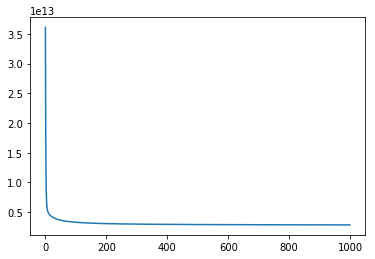

In [10]:
output = GD(X1,y1,1e-6)# J,w,y_hat
plt.plot(output[0])

In [11]:
N_train = X1.shape[0]
N_cv = X2.shape[0]

J_train = (1/N_train)*OLS(y1, output[2])

y_hat_cv = X2.dot(output[1])

J_cv = (1/N_cv)*OLS(y2, y_hat_cv)

print("Training Error: {}".format(J_train))
print("Validation Error: {}".format(J_cv))




Training Error: 8819096.326106947
Validation Error: 8980771.838921519


In [12]:
cv = J_Va (X1,y1,X2,y2)
J_train = [i for i,j,k,m in cv]
J_cv = [j for i,j,k,m in cv]
lambda1 = [k for i,j,k,m in cv]
lambda2 = [m for i,j,k,m in cv]

o = J_cv.index(min(J_cv))

l1 = lambda1[o]
l2 = lambda2[o]

print("Lambda 1: {}".format(l1))
print("Lambda 2: {}".format(l2))

Lambda 1: 2
Lambda 2: 1


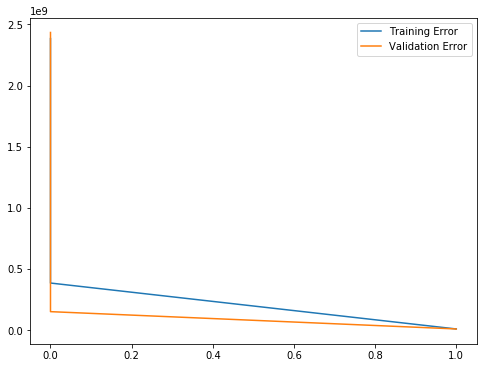

In [13]:
plt.figure(figsize = (8,6))
plt.plot(lambda2, J_train, label = "Training Error")
plt.plot(lambda2, J_cv, label = "Validation Error")
plt.legend()

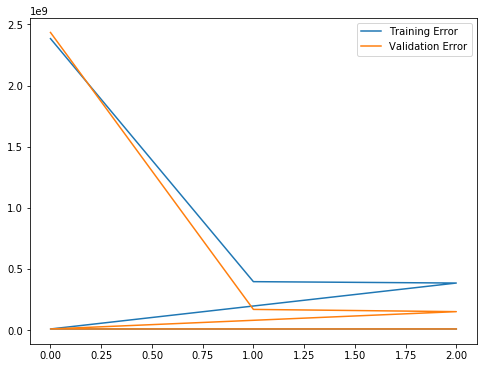

In [14]:
plt.figure(figsize = (8,6))
plt.plot(lambda1, J_train, label = "Training Error")
plt.plot(lambda1, J_cv, label = "Validation Error")
plt.legend()

In [15]:
w = np.random.randn(X1.shape[1])

eta = 1e-6
epochs = int(1e3)

for t in range(epochs):
    y_hat_train = X1.dot(w)
    w -= eta*(X1.T.dot(y_hat_train - y1) + l2*w + l1*np.sign(w))

    
y_hat_test = X3.dot(w)

N_test = X3.shape[0]
J_test = (1/N_test)*OLS(y3, y_hat_test)

print("Test Error: {}".format(J_test))

print("R Squared: {}".format(R2(y3, y_hat_test)))

Test Error: 8889196.452810679
R Squared: 0.6418107889206053


W = []
eta = 1e-6
w = np.random.randn(X1.shape[1])
for i in range (100):
    y_hat_train = X1.dot(w)
    W.append(OLS(y1,y_hat_train))
    w -= eta*(X1.T.dot(y_hat_train - y1) + l2*w + l1*np.sign(w))




plt.plot(W)

y_hat_test = X3.dot(w)

N_test = X3.shape[0]
J_test = (1/N_test)*OLS(y3, y_hat_test)

print("Test Error: {}".format(J_test))

R2(y3, y_hat_test)

w = np.random.randn(X1.shape[1])
eta = 3e-5
y_hat_train = X1.dot(w)
w -= eta*(X1.T.dot(y_hat_train - y1) + l2*w + l1*np.sign(w))

y_hat_test = X3.dot(w)
J_test = (1/N_test)*OLS(y3, y_hat_test)
print("Test Error: {}".format(J_test))

np.isnan(J_test).any()


This is the different data frames I used 
*************************************************************
df = pd.read_csv("./Project2Data/BlackFriday.csv")

df.drop(['User_ID', 'Product_ID'], axis=1, inplace = True)

columns_to_1hot = ["Stay_In_Current_City_Years",'Gender','City_Category','Age','Occupation','Marital_Status','Product_Category_1','Product_Category_2','Product_Category_3']

Training Error: 8963383.799396714

Validation Error: 9126741.288465848

*************************************************************

df.fillna(0,inplace = True)
df["All_Product"] = df["Product_Category_1"] + df["Product_Category_2"]+ df["Product_Category_3"]
df["1_2_Product"] = df["Product_Category_1"] + df["Product_Category_2"]
df["1_3_Product"] = df["Product_Category_1"]+ df["Product_Category_3"]
df["2_3_Product"] = df["Product_Category_2"]+ df["Product_Category_3"]
columns_to_1hot = ["2_3_Product","1_3_Product","1_2_Product",'All_Product',"Stay_In_Current_City_Years",
                   'Gender','City_Category','Age','Occupation','Marital_Status',
                   'Product_Category_1','Product_Category_2','Product_Category_3']
                   
Training Error: 8856642.625530493
Validation Error: 9008174.920970961

*************************************************************

df["Occupation"] = df["Occupation"].map(str)
df["Marital_Status"] = df["Marital_Status"].map(str)
df["Age/Occupation"] = df["Age"] + df["Occupation"]
df["Age/Gender"] = df["Age"]+ df["Gender"]
df["Age/Marital"] = df["Age"] + df["Marital_Status"]
df["Gender/Marital"] = df["Gender"]+ df["Marital_Status"]
df["All_Product"] = df["Product_Category_1"] + df["Product_Category_2"]+ df["Product_Category_3"]
df["1_2_Product"] = df["Product_Category_1"] + df["Product_Category_2"]
df["1_3_Product"] = df["Product_Category_1"]+ df["Product_Category_3"]
df["2_3_Product"] = df["Product_Category_2"]+ df["Product_Category_3"]
columns_to_1hot = ["Age/Occupation","Age/Gender","Age/Marital","Gender/Marital","2_3_Product","1_3_Product","1_2_Product",'All_Product',"Stay_In_Current_City_Years",
                   'Gender','City_Category','Age','Occupation','Marital_Status',
                   'Product_Category_1','Product_Category_2','Product_Category_3']
                   
Training Error: 8819096.326106947
Validation Error: 8980771.838921519